In [1]:
import numpy as np
from qiskit import *
from qiskit_aer import AerSimulator
import matplotlib.pyplot as plt

In [2]:
class QuantumTeleportation:
    def __init__(self, information):
        """
        information: An integer that you want to encode as an n-bit string and then teleport.
        """
        # Convert integer to binary (remove '0b'), store length
        self.bin_info = bin(information)[2:]
        self.information_length = len(self.bin_info)
        
        self.simulator = AerSimulator()
        self.circuit = None
        self.counts = None

    def create_circuit(self):
        """
        Create a quantum circuit with 3*n qubits and 3 classical registers:
        """
        n = self.information_length
        num_qubits = 3 * n

        self.c0 = ClassicalRegister(n, 'c0')
        self.c1 = ClassicalRegister(n, 'c1')
        self.c2 = ClassicalRegister(n, 'c2')

        qc = QuantumCircuit(num_qubits)
        qc.add_register(self.c0)
        qc.add_register(self.c1)
        qc.add_register(self.c2)

        self.circuit = qc
        return True
    
    def encode_information(self):
        """
        Encode the binary string into qubits [0..n-1].
        If bit == '1', apply X.
        """
        qc = self.circuit
        for i, bit in enumerate(reversed(self.bin_info)):
            if bit == '1':
                qc.x(i)
        return True
    
    def create_epr_pairs(self):
        """
        For i in 0..n-1:
          - qubit (n + i) = Alice's half
          - qubit (2n + i) = Bob's half
        Create the EPR pair by H on Alice, then CX(Alice->Bob).
        """
        qc = self.circuit
        n = self.information_length
        
        for i in range(n):
            alice = n + i
            bob   = 2*n + i
            qc.h(alice)
            qc.cx(alice, bob)
        return True
    
    def teleport(self):
        """
        Perform teleportation on each bit i.
        """
        qc = self.circuit
        n = self.information_length

        for i in range(n):
            msg = i
            alice = n + i
            bob   = 2*n + i
            
            qc.barrier()
            qc.cx(msg, alice)
            qc.h(msg)
            qc.barrier()

            qc.measure(msg, i)          # c0[i]
            qc.measure(alice, n + i)    # c1[i]
            
            qc.x(bob).c_if(self.c1[i], 1)
            qc.z(bob).c_if(self.c0[i], 1)

        qc.barrier()
        for i in range(n):
            bob = 2*n + i
            qc.measure(bob, 2*n + i)

        return True

    def run(self, shots=1024):
        """
        Transpile and run.
        """
        qc = self.circuit
        print("Circuit depth:", qc.depth())
        print("Number of qubits:", qc.num_qubits)

        compiled_circuit = transpile(qc, self.simulator)
        result = self.simulator.run(compiled_circuit, shots=shots).result()
        counts = result.get_counts(qc)
        self.counts = counts
        return counts
    
    def accuracy(self):
        success_counts = 0
        total_count = 0
        for outcome, freq in self.counts.items():
            c2_str, c1_str, c0_str = outcome.split()
            if c2_str == self.bin_info:
                success_counts += freq
            total_count += freq
        return success_counts / total_count
    
    def draw_circuit(self):
        fig = self.circuit.draw("mpl")
        plt.show()
        return fig

In [3]:
info = 19
teleporter = QuantumTeleportation(information=info)
teleporter.create_circuit()
teleporter.encode_information()
teleporter.create_epr_pairs()
teleporter.teleport()
counts = teleporter.run(shots=1024)
[print(i, j) for i,j in zip(list(counts.keys())[:10], list(counts.values())[:10])]
print("etc...")

Circuit depth: 28
Number of qubits: 15
10011 00111 00100 1
10011 00000 11011 1
10011 00101 11100 1
10011 00011 00111 1
10011 10100 11011 1
10011 01011 10111 1
10011 10000 10100 1
10011 01110 00100 1
10011 10110 01100 2
10011 01101 11110 1
etc...


In [4]:
success_prob = teleporter.accuracy()
print(f"Bob's final measurement is {info} in {success_prob:.2%} of shots.")

Bob's final measurement is 19 in 100.00% of shots.


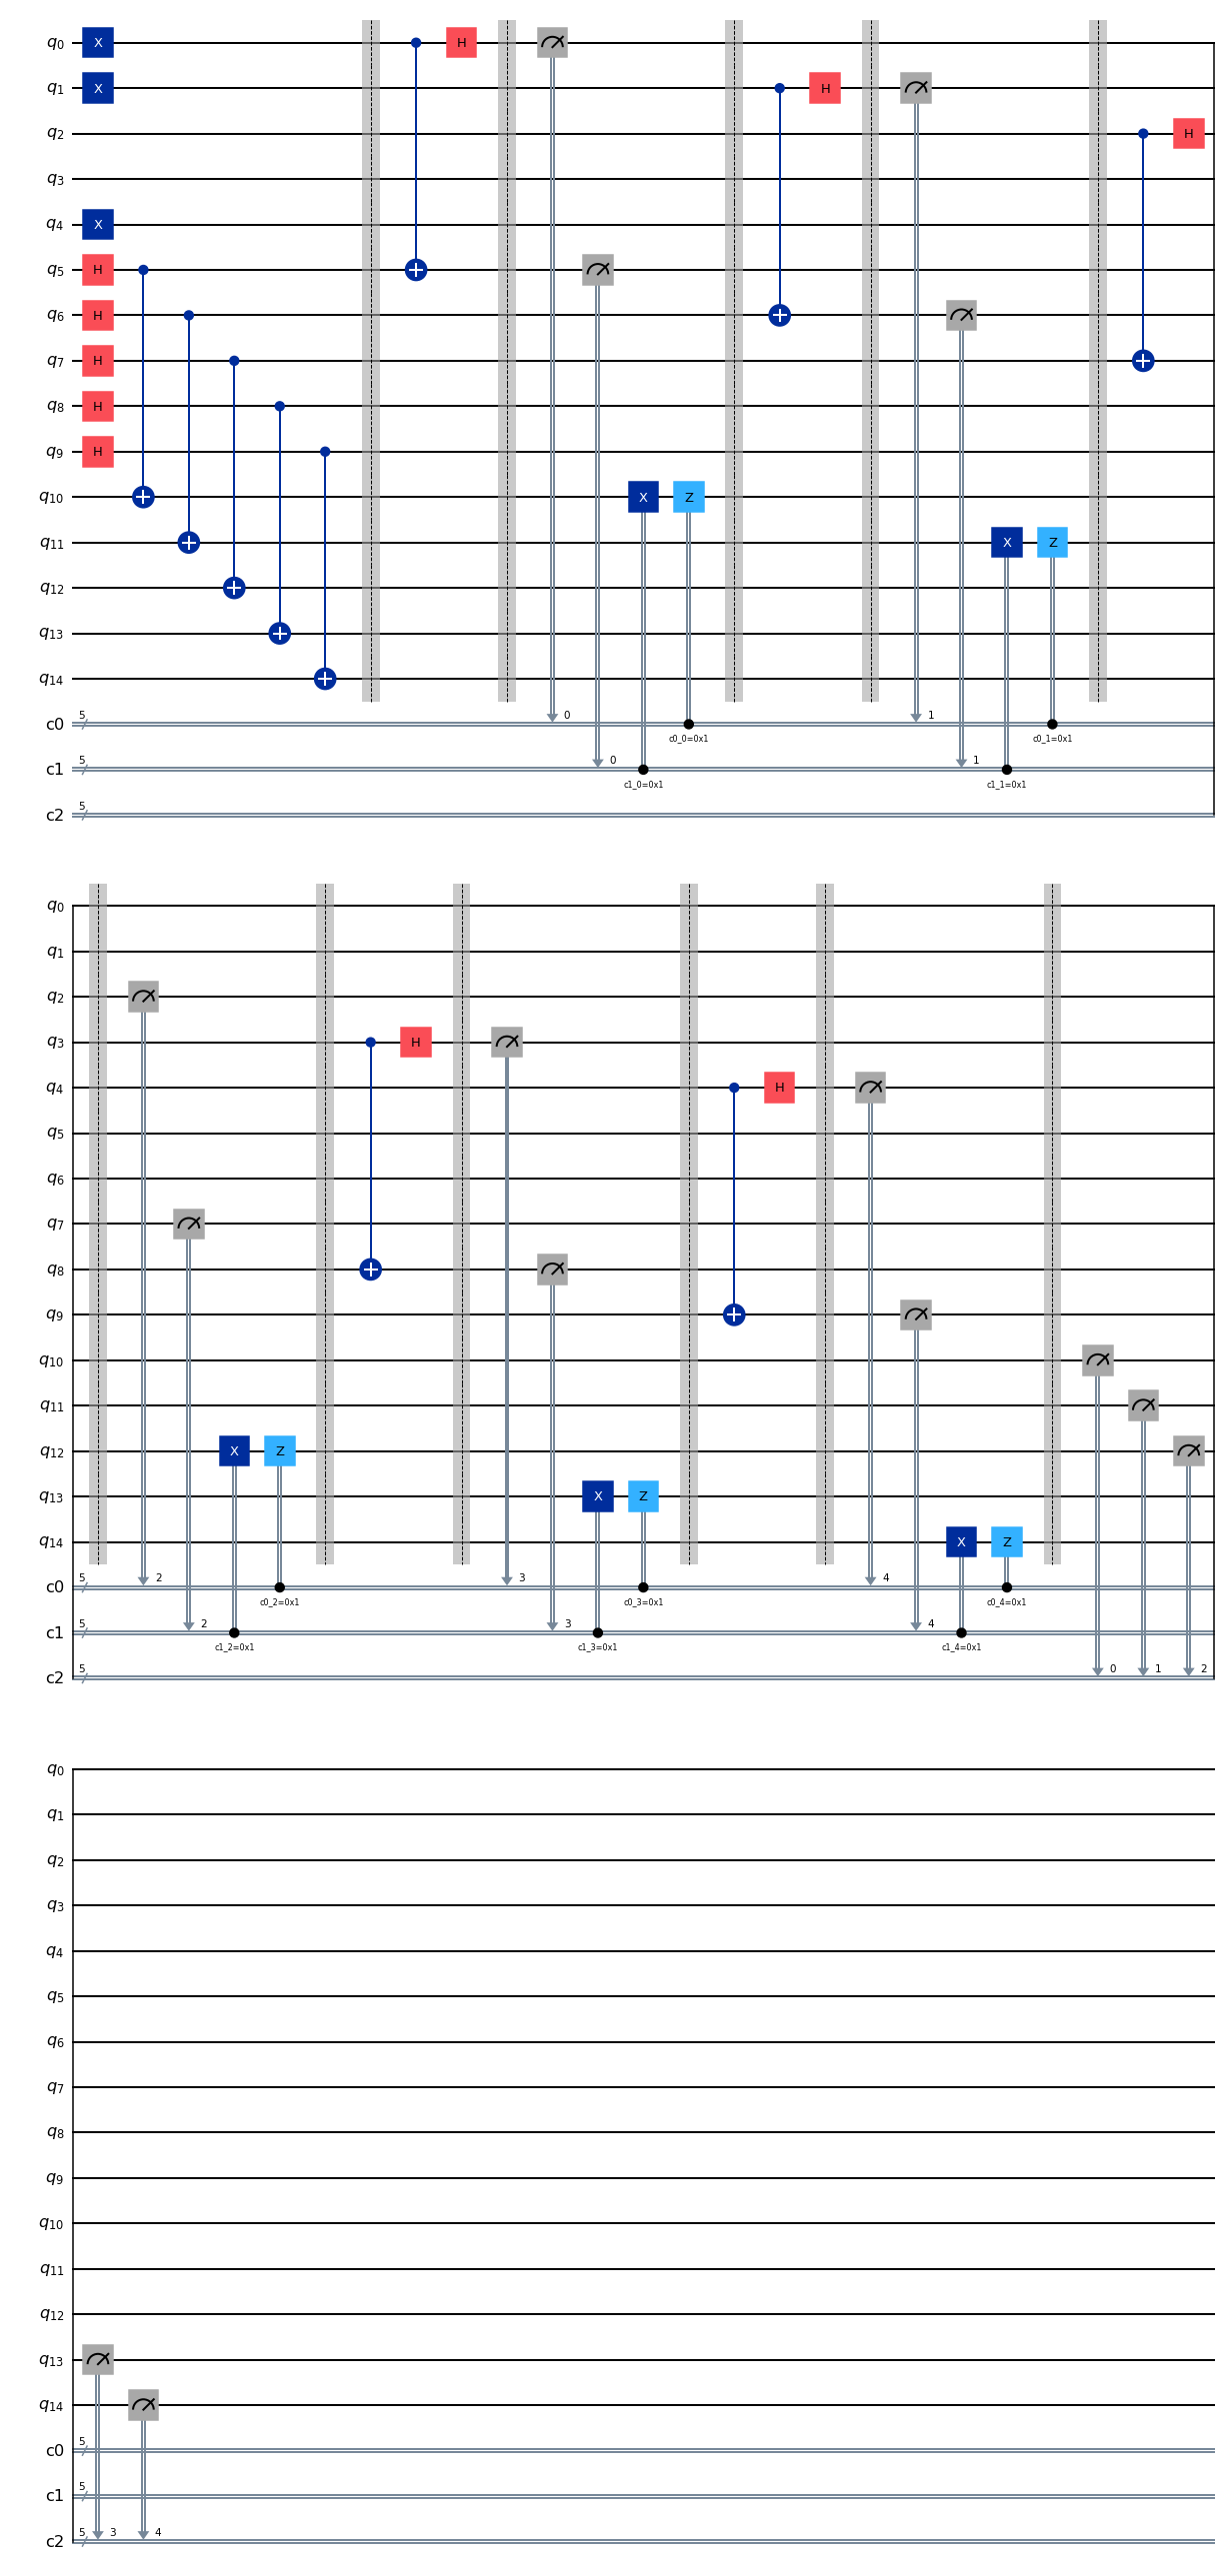

In [5]:
teleporter.draw_circuit()